# Titanic - Machine Learning from Disaster

## Overview

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, the goal is to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Problem Definition

> what sorts of people were more likely to survive?

### Data

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set was used to build the machine learning models. For the training set, it provides the outcome (also known as the “ground truth”) for each passenger. The model was based on “features” like passengers’ gender and class. 

The test set was used to see how well the model performed on unseen data. For each passenger in the test set, the model was trained to predict whether or not they survived the sinking of the Titanic.

Also includes is the gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what the submission file should look like.

For more details, checkout the [data dictionary](https://www.kaggle.com/competitions/titanic/data)

### Evaluation

> The score is the percentage of passengers the model correctly predicted. This is known as accuracy.

### Features
#### Data Analysis EDA

In [3]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
import optuna as opt
import xgboost as xgb
import catboost as cat
%matplotlib inline

In [46]:
# load data 
df = pd.read_csv('data/train.csv')
df.sample(frac=.2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
313,314,0,3,"Hendekovic, Mr. Ignjac",male,28.0,0,0,349243,7.8958,NaN,S
585,586,1,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.6500,E68,S
844,845,0,3,"Culumovic, Mr. Jeso",male,17.0,0,0,315090,8.6625,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
875,876,1,3,"Najib, Miss. Adele Kiamie ""Jane""",female,15.0,0,0,2667,7.2250,NaN,C
138,139,0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,NaN,S
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,B35,C
279,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S


In [47]:
# check that the `Passengerid` feature is unique for all samples
df['PassengerId'].value_counts().sum() , df.shape[0]

(np.int64(891), 891)

In [48]:
# quick overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Note: 
- There are 891 samples/rows and 12 columns/varibles (11 features, 1 label).
- There are some non-numeric features.
- Based on the total number of rows there are some missing values in some features like `Age`, `Cabin`...

In [49]:
# check dimension of data
df.shape 

(891, 12)

In [50]:
# check that labels have only 2 unique values
df.Survived.value_counts() 

Survived
0    549
1    342
Name: count, dtype: int64

In [51]:
# quick descriptive statistics
df.describe() 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Note:
- The majority of passengers came with at least one person (sibling, spouse, parent, or child)
- There seem to be an outlier in the `Age` column - `0.42  `, need to visualize to comfirm. Might be an outlier, or a toddler i.e 42% of 12 (couple of months old).
- Seems some person's did not pay for the fare, min value is `0` might be crew members, need to visualize.
- Less passengers survived.
- The majority of passengers bought 3rd class tickets. 
- The majority of passegers were young adults less than 40 years of age.

### Data Visualization

In [52]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [53]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

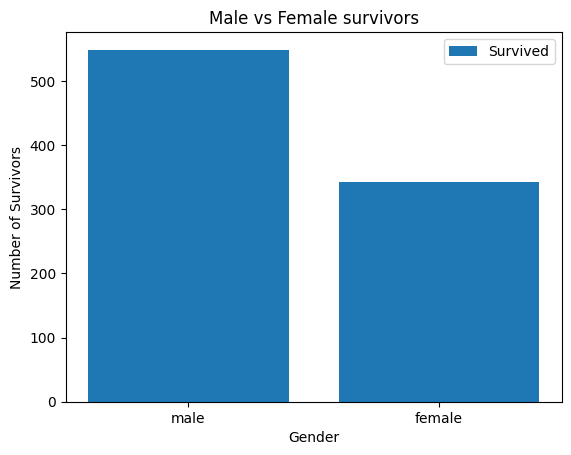

In [59]:
# check the number of survivors with respect to gender 
fig, ax = plt.subplots()
ax.bar(df.Sex.unique(), df.Survived.value_counts(), label='Survived');
ax.set(xlabel='Gender',
       ylabel='Number of Survivors',
       title="Male vs Female survivors")
ax.legend();


In [55]:
pd.crosstab(df.Sex, df.Survived.value_counts())

count,342,549
Sex,,
female,1,0
male,0,1


In [56]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Sample data
# data = {
#     'Fruit': ['Apples', 'Oranges', 'Bananas'],
#     'Sales_Q1': [30, 25, 35],
#     'Sales_Q2': [28, 27, 30]
# }
# df = pd.DataFrame(data)

# # Set 'Fruit' as index (for clean x-axis labels)
# df.set_index('Fruit')[['Sales_Q1', 'Sales_Q2']].plot.bar(legend=True)

# # Optional: Customize title and labels
# plt.title('Sales by Quarter')
# plt.xlabel('Fruits')
# plt.ylabel('Units Sold')

# # Show plot
# plt.tight_layout()
# plt.show()

## Modelling

### Data Modelling EDA